In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import casadi as cas
import pickle
import copy as cp

import argparse

PROJECT_PATH = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/'
sys.path.append(PROJECT_PATH)

import src.MPC_Casadi as mpc
import src.TrafficWorld as tw
import src.IterativeBestResponseMPCMultiple as mibr
import src.car_plotting_multiple as cmplot

np.set_printoptions(precision=2)

In [2]:
# random_seed = args.random_seed[0]

svo_theta = np.pi/4.0

random_seed = 3
NEW = True
if NEW:
    optional_suffix = "faster_ibr"
    subdir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + optional_suffix
    folder = "results/" + subdir_name + "/"
    os.makedirs(folder)
    os.makedirs(folder+"imgs/")
    os.makedirs(folder+"data/")
    os.makedirs(folder+"vids/")
    os.makedirs(folder+"plots/")
else:
    subdir_name = "20200224-103456_real_dim_CA"
    folder = "results/" + subdir_name + "/"
print(folder)
if random_seed > 0:
    np.random.seed(random_seed)

results/20200306_163623faster_ibr/


In [3]:
T = 3
dt = 0.2
N = int(T/dt) #Number of control intervals
print(N)
world = tw.TrafficWorld(2, 0, 1000)
n_other = 4

all_other_x0 = []
all_other_u = []
all_other_MPC = []
next_x0 = 0
for i in range(n_other):
    x1_MPC = mpc.MPC(dt)
    x1_MPC.n_circles = 3
    x1_MPC.theta_iamb =  svo_theta
    x1_MPC.N = N
    
    
    

    x1_MPC.k_u_v = 0.01
    x1_MPC.k_u_delta = .00001
    x1_MPC.k_change_u_v = 0.01
    x1_MPC.k_change_u_delta = 0

    x1_MPC.k_s = 0
    x1_MPC.k_x = 0
    x1_MPC.k_x_dot = -1.0 / 100.0
    x1_MPC.k_lat = 0.001
    x1_MPC.k_lon = 0.0
#     x1_MPC.min_v = 0.8*initial_speed
#     x1_MPC.max_v = 35 * 0.447 # m/s


    x1_MPC.k_phi_error = 0.001
    x1_MPC.k_phi_dot = 0.0
    
    
    
    
#     x1_MPC.k_final = 0.0
#     x1_MPC.k_s = 0
#     x1_MPC.k_x = 0
#     x1_MPC.k_x_dot = -1.0 / 100.0    

#     # x1_MPC.k_u_v = 1.0
#     # x1_MPC.k_u_delta = 1.00
#     # x1_MPC.k_lat = .25
#     # x1_MPC.k_change_u_v = .50
#     # x1_MPC.k_change_u_delta = .50    

#     x1_MPC.k_u_v = .10
#     x1_MPC.k_u_delta = .01
#     x1_MPC.k_lat = 5.0
#     x1_MPC.k_lon = 0.01
#     x1_MPC.k_phi_error = 0.05 
#     x1_MPC.k_change_u_v = .01
#     x1_MPC.k_change_u_delta = .01        

#     NO_GRASS = False
#     x1_MPC.min_y = world.y_min        
#     x1_MPC.max_y = world.y_max
#     if NO_GRASS:
#         x1_MPC.min_y += world.grass_width
#         x1_MPC.max_y -= world.grass_width
    # x1_MPC.k_phi_error = 25

    if i%2 == 0:
        lane_number = 0
        next_x0 += x1_MPC.L + 2*x1_MPC.min_dist
    else:
        lane_number = 1

    initial_speed = 20 * 0.447 # m/s
    initial_speed = x1_MPC.max_v
    initial_speed = 0.75*x1_MPC.max_v

    # large_world = tw.TrafficWorld(2, 0, 1000, 5.0)
    traffic_world = tw.TrafficWorld(2, 0, 1000)


    x1_MPC.fd = x1_MPC.gen_f_desired_lane(traffic_world, lane_number, True)

    x0 = np.array([next_x0, traffic_world.get_lane_centerline_y(lane_number), 0, 0, initial_speed, 0]).T
    u1 = np.zeros((2,N))
    # u1[0,:] = np.clip(np.pi/180 *np.random.normal(size=(1,N)), -2 * np.pi/180, 2 * np.pi/180)
    SAME_SIDE = False
    if lane_number == 1 or SAME_SIDE:
        u1[0,0] = 2 * np.pi/180
    else:
        u1[0,0] = -2 * np.pi/180
    u1[0,0] = 0 ###
    all_other_MPC += [x1_MPC]
    all_other_x0 += [x0]
    all_other_u += [u1]    
pickle.dump(x1_MPC, open(folder + "data/"+"mpc%d"%i + ".p",'wb'))


amb_MPC = cp.deepcopy(x1_MPC)

amb_MPC.theta_iamb = 0.0

amb_MPC.k_u_v = 0.01
amb_MPC.k_u_delta = .00001
amb_MPC.k_change_u_v = 0.01
amb_MPC.k_change_u_delta = 0

amb_MPC.k_s = 0
amb_MPC.k_x = 0
amb_MPC.k_x_dot = -1.0 / 100.0
amb_MPC.k_lat = 0.001
amb_MPC.k_lon = 0.0
amb_MPC.min_v = 0.8*initial_speed
amb_MPC.max_v = 35 * 0.447 # m/s


amb_MPC.k_phi_error = 0.001
amb_MPC.k_phi_dot = 0.0

NO_GRASS = False
amb_MPC.min_y = world.y_min        
amb_MPC.max_y = world.y_max
if NO_GRASS:
    amb_MPC.min_y += world.grass_width
    amb_MPC.max_y -= world.grass_width
# x1_MPC.k_phi_error = 25
amb_MPC.fd = amb_MPC.gen_f_desired_lane(world, 0, True)
pickle.dump(amb_MPC, open(folder + "data/"+"mpcamb" + ".p",'wb'))
x0_amb = np.array([0, 0, 0, 0, initial_speed , 0]).T
uamb = np.zeros((2,N))
# uamb[0,:] = np.clip(np.pi/180 * np.random.normal(size=(1,N)), -2 * np.pi/180, 2 * np.pi/180)
uamb[0,0] = np.pi/180 * 5
# uamb[0,0] = 2 * np.pi/180
# amb_MPC.radius = 0.1

n_rounds_mpc = 20 # seconds
number_ctrl_pts_executed = 5  #dt = 0.2
actual_xamb = np.zeros((6, n_rounds_mpc*number_ctrl_pts_executed + 1))
actual_uamb = np.zeros((2, n_rounds_mpc*number_ctrl_pts_executed))
actual_xothers = [np.zeros((6, n_rounds_mpc*number_ctrl_pts_executed + 1)) for i in range(n_other)]
actual_uothers = [np.zeros((2, n_rounds_mpc*number_ctrl_pts_executed)) for i in range(n_other)]

# actual_xamb[:,0] = x0_amb

actual_all_other_x0 = [np.zeros((6, 2*N)) for i in range(n_other)]
XAMB_ONLY = True
WARM = True
UWARM = True

xamb = None
ibr_sub_it = 1

uamb_warm = np.zeros((2,N))
uamb_warm[0,0] = np.pi/4
uamb_warm[0,1:5] = 0
uamb_warm[0,5:10] = -np.pi/4
xamb_warm = np.zeros((6,N+1))
xamb_warm[1,:] = traffic_world.get_lane_centerline_y(1) * 0.5
xamb_warm[0,:] = amb_MPC.dt * x0_amb[4] * np.arange(N+1)

all_other_xwarm = [i for i in range(n_other)]
for i_mpc in range(n_rounds_mpc):
    runtimeerrors = 0
#     min_slack = 99999.0
    min_slack = np.infty
    if i_mpc > 0:
        ### THIS SHOULD BE CHANGED FOR GLOBAL TRUTH?
        all_other_u = [np.zeros((2,N)) for i in range(n_other)] ## <--We are setting the other vehicle inputs
        
        
        x0_amb = xamb[:,number_ctrl_pts_executed] # NEW INITIAL STATE
        for i in range(len(all_other_x0)):
            all_other_x0[i] = xothers[i][:,number_ctrl_pts_executed]
        uamb_warm = np.concatenate((uamb[:, number_ctrl_pts_executed:], np.tile(uamb[:,-1:],(1, number_ctrl_pts_executed))),axis=1) ##
        xamb_warm = np.concatenate((xamb[:, number_ctrl_pts_executed:] , np.tile(xamb[:,-1:],(1, number_ctrl_pts_executed))),axis=1)  ## <--- Warmstart            
        for i in range(len(all_other_x0)):
            all_other_xwarm[i] = np.concatenate((xothers[i][:, number_ctrl_pts_executed:] , np.tile(xothers[i][:,-1:],(1, number_ctrl_pts_executed))),axis=1)  ## <--- Warmstart            
                    
    actual_t = i_mpc * number_ctrl_pts_executed
    print("x0amb", x0_amb)
    n_total_round = 5
    for n_round in range(n_total_round):   
        response_MPC = amb_MPC
        response_x0 = x0_amb

        nonresponse_MPC_list = all_other_MPC
        nonresponse_x0_list = all_other_x0
        nonresponse_u_list = all_other_u
        
        bri = mibr.IterativeBestResponseMPCMultiple(response_MPC, None, nonresponse_MPC_list )
        bri.k_slack = 1000.0
        bri.k_CA = 10.0
        bri.generate_optimization(N, T, response_x0, None, nonresponse_x0_list,  1, slack=True)
#         for slack_var in bri.slack_vars_list: ## Added to constrain slacks
#             bri.opti.subject_to(cas.vec(slack_var) < 10.50)
        INFEASIBLE = True
        if i_mpc >= 0:
            print(xamb_warm[0:2,:])
            bri.opti.set_initial(bri.x_opt, xamb_warm)
            bri.opti.set_initial(bri.u_opt, uamb_warm)
        
#         bri.opti.subject_to(bri.x_opt[1,:] > 0.0)
        bri.solve(None, nonresponse_u_list)
        x1, u1, x1_des, _, _, _, other_x, other_u, other_des = bri.get_solution()
        xothers = other_x # initialize the x values of the other vehicles
        uothers = other_u
        xothers_des = other_des
        print("i_mpc %d n_round %d i %02d Cost %.02f Slack %.02f "%(i_mpc, n_round, i, bri.solution.value(bri.total_svo_cost), bri.solution.value(bri.slack_cost)))
        print("J_i %.03f,  J_j %.03f, Slack %.03f, CA  %.03f"%(bri.solution.value(bri.response_svo_cost), bri.solution.value(bri.other_svo_cost), bri.solution.value(bri.k_slack*bri.slack_cost), bri.solution.value(bri.k_CA*bri.collision_cost)))
        print("Dir:", subdir_name)
        INFEASIBLE = False
        if bri.solution.value(bri.slack_cost) <= min_slack:
            uamb = u1
            xamb = x1
            xamb_des = x1_des
            # all_other_u[i] = u1
            file_name = folder + "data/"+'%03d'%ibr_sub_it
            mibr.save_state(file_name, x1, u1, x1_des, other_x, other_u, other_des)
            mibr.save_costs(file_name, bri)          
#         except RuntimeError:
#             print("Max Iterations or Infeasible")
#             INFEASIBLE = True
#             runtimeerrors += 1                
        ibr_sub_it +=1
        XAMB_ONLY = False
        if XAMB_ONLY:
            pass
        else:
            for i in range(len(all_other_MPC)):
                response_MPC = all_other_MPC[i]
                response_x0 = all_other_x0[i]

                nonresponse_MPC_list = all_other_MPC[:i] + all_other_MPC[i+1:]
                nonresponse_x0_list = all_other_x0[:i] + all_other_x0[i+1:]

                # all_other_u changes over time
                nonresponse_u_list = all_other_u[:i] + all_other_u[i+1:]

                bri = mibr.IterativeBestResponseMPCMultiple(response_MPC, amb_MPC, nonresponse_MPC_list )
                bri.k_slack = 1000.0
                bri.k_CA = 10.0
                bri.generate_optimization(N, T, response_x0, x0_amb, nonresponse_x0_list,  1, slack=True)
                WARM = True
                try:
                    if WARM:
                        bri.opti.set_initial(bri.x_opt, xothers[i])
                        bri.opti.set_initial(bri.u_opt, uothers[i])

                    bri.solve(uamb, nonresponse_u_list)
                    x1, u1, x1_des, xamb, uamb, xamb_des, other_x, other_u, other_des = bri.get_solution()
                    print("i_mpc %d n_round %d  i %02d Cost %.02f Slack %.02f "%(i_mpc, n_round, i, bri.solution.value(bri.total_svo_cost), bri.solution.value(bri.slack_cost)))
                    print("Dir:", subdir_name)

                    if bri.solution.value(bri.slack_cost) <= min_slack:
                        # Update the responder
                        all_other_u[i] = u1

                        #for saving
                        xothers = other_x[:i] + [x1] + other_x[i:]
                        uothers = other_u[:i] + [u1] + other_u[i:]
                        xothers_des = other_des[:i] + [x1_des] + other_des[i:]

                        file_name = folder + "data/"+'%03d'%ibr_sub_it
                        mibr.save_state(file_name, xamb, uamb, xamb_des, xothers, uothers, xothers_des)
                        mibr.save_costs(file_name, bri)
                    else: 
                        print("Slack too large")    
                except RuntimeError:
                    print("Max Iterations or Infeasible")
                    runtimeerrors += 1   
                ibr_sub_it+=1

    file_name = folder + "data/"+'r%02d%03d'%(i_mpc, n_round)
    if not INFEASIBLE:
        for cost in bri.car1_costs_list:
            print("%.04f"%bri.solution.value(cost))
        print(bri.solution.value(bri.k_CA * bri.collision_cost), bri.solution.value(bri.collision_cost))
        print(bri.solution.value(bri.k_slack * bri.slack_cost), bri.solution.value(bri.slack_cost))
        mibr.save_state(file_name, xamb, uamb, xamb_des, xothers, uothers, xothers_des)
        mibr.save_costs(file_name, bri)
        actual_t = i_mpc * number_ctrl_pts_executed
        actual_xamb[:,actual_t:actual_t+number_ctrl_pts_executed+1]  = xamb[:,:number_ctrl_pts_executed+1]
        print(i_mpc, xamb[0:2,:number_ctrl_pts_executed+1])

        actual_uamb[:,actual_t:actual_t+number_ctrl_pts_executed] = uamb[:,:number_ctrl_pts_executed]

        for i in range(len(xothers)):
            actual_xothers[i][:,actual_t:actual_t+number_ctrl_pts_executed+1] = xothers[i][:,:number_ctrl_pts_executed+1]
            actual_uothers[i][:,actual_t:actual_t+number_ctrl_pts_executed] = uothers[i][:,:number_ctrl_pts_executed]
#             all_other_u[i] = np.concatenate((uothers[i][:, number_ctrl_pts_executed:],uothers[i][:,:number_ctrl_pts_executed]),axis=1)
    else:
        raise Exception("Xamb is None", i_mpc, n_round, "slack cost", bri.solution.value(bri.slack_cost))

15
x0amb [0.   0.   0.   0.   8.38 0.  ]
[[ 0.    1.68  3.35  5.03  6.71  8.38 10.06 11.73 13.41 15.09 16.76 18.44
  20.12 21.79 23.47 25.14]
 [ 1.85  1.85  1.85  1.85  1.85  1.85  1.85  1.85  1.85  1.85  1.85  1.85
   1.85  1.85  1.85  1.85]]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  10.65ms ( 16.79us)  10.61ms ( 16.74us)       634
       nlp_g  | 280.96ms (443.15us) 279.00ms (440.06us)       634
    nlp_grad  |   1.64ms (  1.64ms)   1.64ms (  1.64ms)         1
  nlp_grad_f  |  16.16ms ( 28.71us)  16.06ms ( 28.53us)       563
  nlp_hess_l  |   3.63 s (  6.29ms)   

In [ ]:
bri.opti.debug.value(bri.x_opt[:,0])

In [6]:
bri.opti.debug.show_infeasibilities()

Violated constraints (tol 0), in order of declaration:
------- i = 96/846 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/MPC_Casadi.py:153 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 0.
------- i = 97/846 ------ 
0 <= -4.33681e-19 <= 0 (viol 4.33681e-19)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/MPC_Casadi.py:153 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 1.
------- i = 98/846 ------ 
0 <= -4.33681e-19 <= 0 (viol 4.33681e-19)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/MPC_Casadi.py:153 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At no

In [4]:
xamb = bri.opti.debug.value(bri.x_opt)
xothers = [bri.opti.debug.value(bri.allother_x_opt[i]) for i in range(n_other)]

(0, 10)

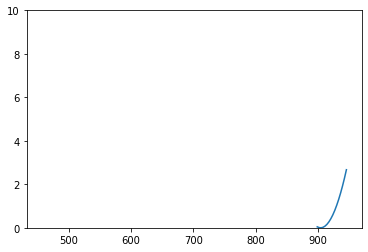

In [6]:
plt.plot(xamb[0,:], xamb[1,:])
for i in range(n_other):
    plt.plot(xothers[i][0,:], xothers[i][1,:])
plt.ylim([0, 10])

In [ ]:
x1_MPC.f(actual_xothers[0][:,0], actual_uothers[0][:,0])

In [ ]:
x1_MPC.F_kutta(x1_MPC.f, actual_xothers[0][:,0], actual_uothers[0][:,0])

In [ ]:
actual_xothers[0][:,1]

In [ ]:
plt.plot(actual_uothers[0][0,:10],'o')

In [ ]:
x0_amb[2]

In [16]:
print(bri.opti.debug.value(bri.x_opt[0,:]))
for i in range(n_other):
    print(bri.opti.debug.value(bri.allother_x_opt[i][0,:]))

[ 8.91 10.87 12.98 15.26 17.69 20.29 23.03 25.84 28.63 31.35 33.94 36.4
 38.72 40.9  42.98 44.98]
[17.97 19.65 21.32 23.   24.68 26.35 28.03 29.7  31.38 33.05 34.73 36.4
 38.08 39.75 41.43 43.1 ]
[ 5.24  6.91  8.59 10.27 11.94 13.62 15.29 16.97 18.65 20.32 22.   23.67
 25.35 27.02 28.69 30.37]


In [15]:
bri.opti.debug.show_infeasibilities()

Violated constraints (tol 0), in order of declaration:
------- i = 96/846 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/MPC_Casadi.py:153 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 0.
------- i = 97/846 ------ 
0 <= -4.33681e-19 <= 0 (viol 4.33681e-19)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/MPC_Casadi.py:153 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 1.
------- i = 98/846 ------ 
0 <= -4.33681e-19 <= 0 (viol 4.33681e-19)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/MPC_Casadi.py:153 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At no